In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
#Check the dataset sizes(in MB)
!du -l drive/toxic_comment/input/*

58941	drive/toxic_comment/input/test.csv
4861	drive/toxic_comment/input/test_labels.csv
67191	drive/toxic_comment/input/train.csv


In [4]:
!pip install wordcloud

In [5]:
!pip install nltk

In [0]:
!conda install -c anaconda nltk

/bin/bash: conda: command not found


In [15]:
!pip install pyldavis  # every time need to install

    100% |████████████████████████████████| 1.6MB 17.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

import pyLDAvis.gensim

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer 

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings
start_time=time.time()

color = sns.color_palette()
sns.set_style("dark")

eng_stopwords = set(stopwords.words("english")) #stopwords
warnings.filterwarnings("ignore")

tokenizer=TweetTokenizer() #tokenizer
lem = WordNetLemmatizer()  #stem,Lemmatize using WordNet’s built-in morphy function. Returns the input word unchanged if it cannot be found in WordNet

%matplotlib inline

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


##Data Exploration

In [0]:
#importing the dataset
train=pd.read_csv("drive/toxic_comment/input/train.csv")
test=pd.read_csv("drive/toxic_comment/input/test.csv")

In [0]:
print(train.tail(10))
print(train.info())

                      id                                       comment_text  \
159561  ffd2e85b07b3c7e4  "\nNo he did not, read it again (I would have ...   
159562  ffd72e9766c09c97  "\n Auto guides and the motoring press are not...   
159563  ffe029a7c79dc7fe  "\nplease identify what part of BLP applies be...   
159564  ffe897e7f7182c90  Catalan independentism is the social movement ...   
159565  ffe8b9316245be30  The numbers in parentheses are the additional ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
159561      0             0        0       0       0        

In [0]:
print(test.tail(10))
print(test.info())

                      id                                       comment_text
153154  fffa8a11c4378854  ==shame on you all!!!== \n\n You want to speak...
153155  fffac2a094c8e0e2  MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...
153156  fffb5451268fb5ba  " \n\n == Unicorn lair discovery == \n\n Suppo...
153157  fffc2b34bbe61c8d  :Disagree. Soviet railways need their own arti...
153158  fffc489742ffe69b  This idiot can't even use proper grammar when ...
153159  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...
153160  fffd7a9a6eb32c16  == Throw from out field to home plate. == \n\n...
153161  fffda9e8d6fafa9e  " \n\n == Okinotorishima categories == \n\n I ...
153162  fffe8f1340a79fc2  " \n\n == ""One of the founding nations of the...
153163  ffffce3fb183ee80  " \n :::Stop already. Your bullshit is not wel...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text   

In [0]:
print(train[train['toxic']==1].shape)
print(train.toxic.value_counts())
print(train.severe_toxic.value_counts())
print(train.obscene.value_counts())
print(train.threat.value_counts())
print(train.insult.value_counts())
print(train.identity_hate.value_counts())

(15294, 8)
0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [0]:
#calculate the ratio of training set and test
nrow_train=train.shape[0]  #rows
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("ratio  :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
ratio  : 51    : 49


There is a 30:70 train: test split and the test set might change in the future too.

Let's take a look at the class imbalance in the train set.

### Class Imbalance:

In [0]:
#caculate the ratio of clean comments
x=train.iloc[:,2:].sum()  #make a statics of each tag of comments
print(x)
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)  #add the value from the 3st to the end columns 
train['clean']=(rowsums==0)
#count number of clean entries
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [0]:
#check the missing values in training set and test set
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')
[ 15294.   1595.   8449.    478.   7877.   1405. 143346.]


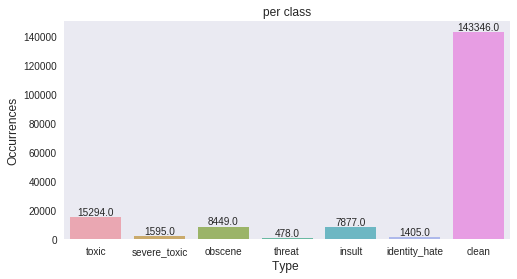

In [0]:
x=train.iloc[:,2:].sum()
print(x.index)
print(x.values)
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("per class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')  #rect.get_x() + rect.get_width()/2: write at the central

plt.show()

* The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
* There are ~95k comments in the training dataset and there are ~35 k tags and ~86k clean comments!?
    * This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene. 

### Multi-tagging:


0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


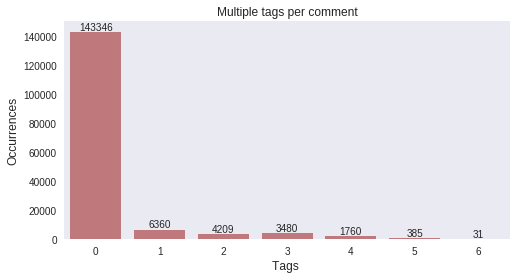

In [0]:
x=rowsums.value_counts()
print(x)

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Only ~10%(不止吧) of the total comments have some sort of toxicity in them. There are certain comments(31) that are marked as all of the above!

# Method1: Use the tokenize function from NLTK package and TfidfVectorizer

## Corpus cleaning:



In [11]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
corpus=merge.comment_text
print(type(corpus))
for i in range(5):
  print(str(i)+":"+corpus.iloc[i])

<class 'pandas.core.series.Series'>
0:Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
1:D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
2:Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
3:"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences

In [0]:
df=merge.reset_index(drop=True)
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [0]:
print('test:')
print(test_feats.iloc[0])
print('train:')
print(train_feats.iloc[0])

test:
id                                               00001cee341fdb12
comment_text    Yo bitch Ja Rule is more succesful then you'll...
Name: 159571, dtype: object
train:
id                                                0000997932d777bf
comment_text     Explanation\nWhy the edits made under my usern...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
clean                                                         True
Name: 0, dtype: object


In [0]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [0]:
"""
    This function receives comments and returns clean word-list
"""
def clean(comment):
    
    #1.Pre-clean
    #Convert to lower case
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    #remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #2.Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    #3.Clean
    words=[APPO[word] if word in APPO else word for word in words] # (') aphostophe  replacement (ie)   you're --> you are
    words=[lem.lemmatize(word, "v") for word in words] #lemmatize,stem
    words = [w for w in words if not w in eng_stopwords] #remove stopwords
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [0]:
"""
    This function receives comments and returns clean word-list
"""
def clean2(comment):
    
    #1.Pre-clean
    #Convert to lower case
#     comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    #remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #2.Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    #3.Clean
    words=[APPO[word] if word in APPO else word for word in words] # (') aphostophe  replacement (ie)   you're --> you are
    words=[lem.lemmatize(word, "v") for word in words] #lemmatize,stem
    words = [w for w in words if not w in eng_stopwords] #remove stopwords
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [0]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [0]:
clean(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [18]:
print(corpus.iloc[12235])
print(clean2(corpus.iloc[12235]))

"

 NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "
" NOTE If read , follow link , reader see I cite correctly link I add subject . Vidkun add anotations make read oposite , link show " " official " " line take UGLE . I trap User so-called 3RR , peddle POV . Strangly , ALL " " MASONS " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " Thanks " " Brethren . Sitting block give ... "


In [0]:
# clean the all text
clean_corpus=corpus.apply(lambda x :clean(x))

In [0]:
clean_corpus.to_csv("drive/toxic_comment/clean_nltk.csv")

In [0]:
clean_corpus2=corpus.apply(lambda x :clean2(x))

In [0]:
clean_corpus2.to_csv("drive/toxic_comment/clean_nltk2.csv")

In [0]:
# To do next:
# Slang lookup dictionary for sentiments
#http://slangsd.com/data/SlangSD.zip
#http://arxiv.org/abs/1608.05129
# dict lookup 
#https://bytes.com/topic/python/answers/694819-regular-expression-dictionary-key-search


## Direct features:

### 1)Count based features(for unigrams):
Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Python's SKlearn provides 3 ways of creating count features.All three of them first create a vocabulary(dictionary) of words and then create a [sparse matrix](#https://en.wikipedia.org/wiki/Sparse_matrix) of word counts for the words in the sentence that are present in the dictionary. A brief description of them:
* CountVectorizer
    * Creates a matrix with frequency counts of each word in the text corpus
* TF-IDF Vectorizer
    * TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
    * IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization
* HashingVectorizer
    * Creates a hashmap(word to number mapping based on hashing technique) instead of a dictionary for vocabulary
    * This enables it to be more scalable and faster for larger text coprus
    * Can be parallelized across multiple threads
        
Using TF-IDF here.
Note: Using the concatenated dataframe "merge" which contains both text from train and test dataset to ensure that the vocabulary that we create does not missout on the words that are unique to testset.

###Unigrams

In [0]:
### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)

#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
# Convert a collection of raw documents to a matrix of TF-IDF features
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
# Learn vocabulary and idf from training set
tfv.fit(clean_corpus)
print(tfv.get_feature_names())
features = np.array(tfv.get_feature_names())  # 3914个 feature

# Transform documents to document-term matrix.Uses the vocabulary and document frequencies (df) learned by fit (or fit_transform).
train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]]) # 159751 rows-train
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])  # 153164 rows-test

['00', '000', '000000', '01', '02', '03', '04', '05', '06', '07', '08', '084080', '09', '10', '100', '1000', '101', '11', '12', '13', '14', '15', '150', '16', '17', '18', '19', '1945', '1970', '1980', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '1px', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '20th', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2nd', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3px', '3rd', '3rr', '40', '400', '41', '42', '43', '44', '45', '46', '47', '48', '49', '4th', '50', '500', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5px', '5th', '60', '64', '65', '70', '72', '75', '80', '85', '90', '95', '99', 'a7', 'abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'abstract', 'absurd', 'abuse'

In [0]:
print(features.shape) #3914
print(type(features[0]))
for i in range(5):
  print(features[i])
print("train:")
print(type(train_unigrams))
print(type(train_unigrams[0])) # the first row, 显示和第一个评论feature系数不为0的系数 
print(train_unigrams.shape)
print(train_unigrams[0].shape)
print(train_unigrams[0])
print("test:")
print(test_unigrams.shape)
print(test_unigrams[0].shape)
print(test_unigrams[0])

(3914,)
<class 'numpy.str_'>
00
000
000000
01
02
train:
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
(159571, 3914)
(1, 3914)
  (0, 3904)	0.3162595828432214
  (0, 3775)	0.27421886155250236
  (0, 3705)	0.29009838363800794
  (0, 3492)	0.25563751923095973
  (0, 3468)	0.14534674011406643
  (0, 3017)	0.20567184488726756
  (0, 3008)	0.3647253983922807
  (0, 2955)	0.181538175567056
  (0, 2528)	0.13362204967490549
  (0, 2379)	0.1970167196179194
  (0, 2188)	0.14779621781535535
  (0, 1579)	0.3629944634736938
  (0, 1428)	0.2945378816579351
  (0, 1401)	0.35680401390037075
  (0, 1230)	0.14672477701679512
test:
(153164, 3914)
(1, 3914)
  (0, 3903)	0.20746252783991256
  (0, 3886)	0.1346775572482934
  (0, 3825)	0.2833630422114693
  (0, 3820)	0.22118190375016122
  (0, 3692)	0.19893148299939137
  (0, 3543)	0.10058408248154056
  (0, 3524)	0.13224913781726694
  (0, 3236)	0.2317078606725806
  (0, 3186)	0.1492816647445362
  (0, 3080)	0.19436855901821462
  (0, 3070)	0.242165132

In [0]:
 ''' Get top n tfidf values in row and return them with their corresponding feature names.
 '''
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    #[::-1] notes row的索引降序排列,then get the first top_n items
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

'''
Top tfidf features in specific document (matrix row) 
'''

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

''' Return the top n features that on average are most important amongst documents in rows
    indentified by indices in grp_ids(the train_tags which feature's value=1). 
'''
def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    D = Xtr[grp_ids].toarray()
    # set the features's value=0 that 
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
    calculated across documents with the same class label. 
'''
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1] # filter the train_tags which feature's value=1
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [0]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)


In [0]:
print(tfidf_top_n_per_lass[0])  #date frame 

      feature     tfidf
0        fuck  0.082641
1        shit  0.024963
2        suck  0.022605
3        like  0.019794
4       bitch  0.019045
5         ass  0.018233
6      stupid  0.017461
7        stop  0.017323
8   wikipedia  0.016437
9       block  0.016315
10       page  0.015080
11    asshole  0.014594
12      idiot  0.013953
13       edit  0.013859
14       know  0.013807
15     faggot  0.013728
16        gay  0.013621
17       dick  0.013270
18       life  0.012913
19       hell  0.012560


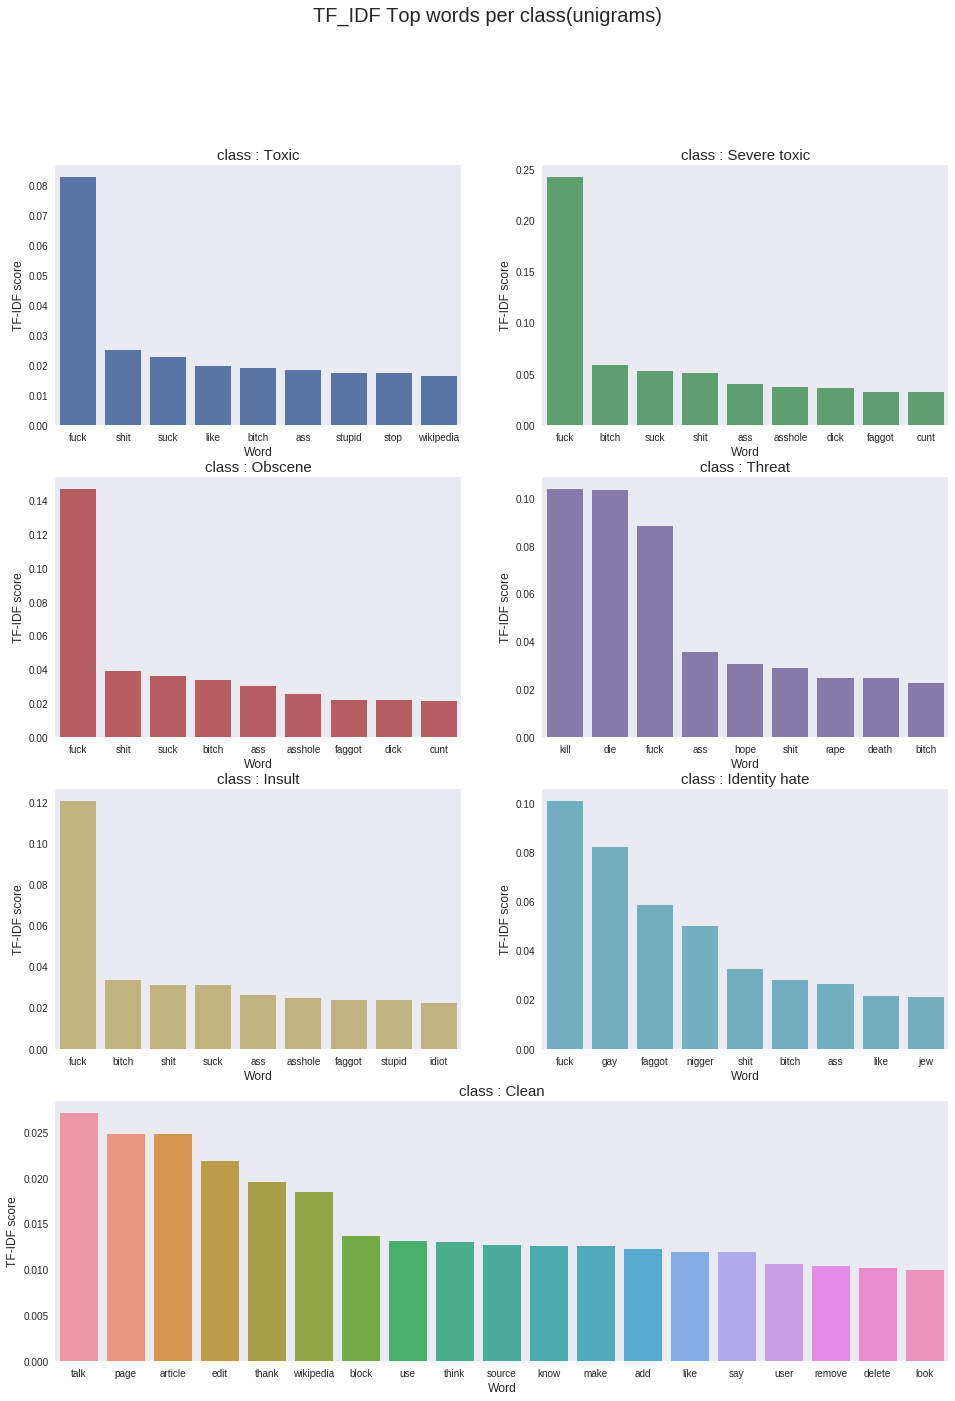

In [0]:
# plot the top-10 TF_IDF score figures for 6 features and clean comments sequentially
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

### Bigrams

In [0]:
#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
#ngram_range=(2,2):Use two words at a time(bigrams)
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')  #min_df=100,  max_features=30000

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

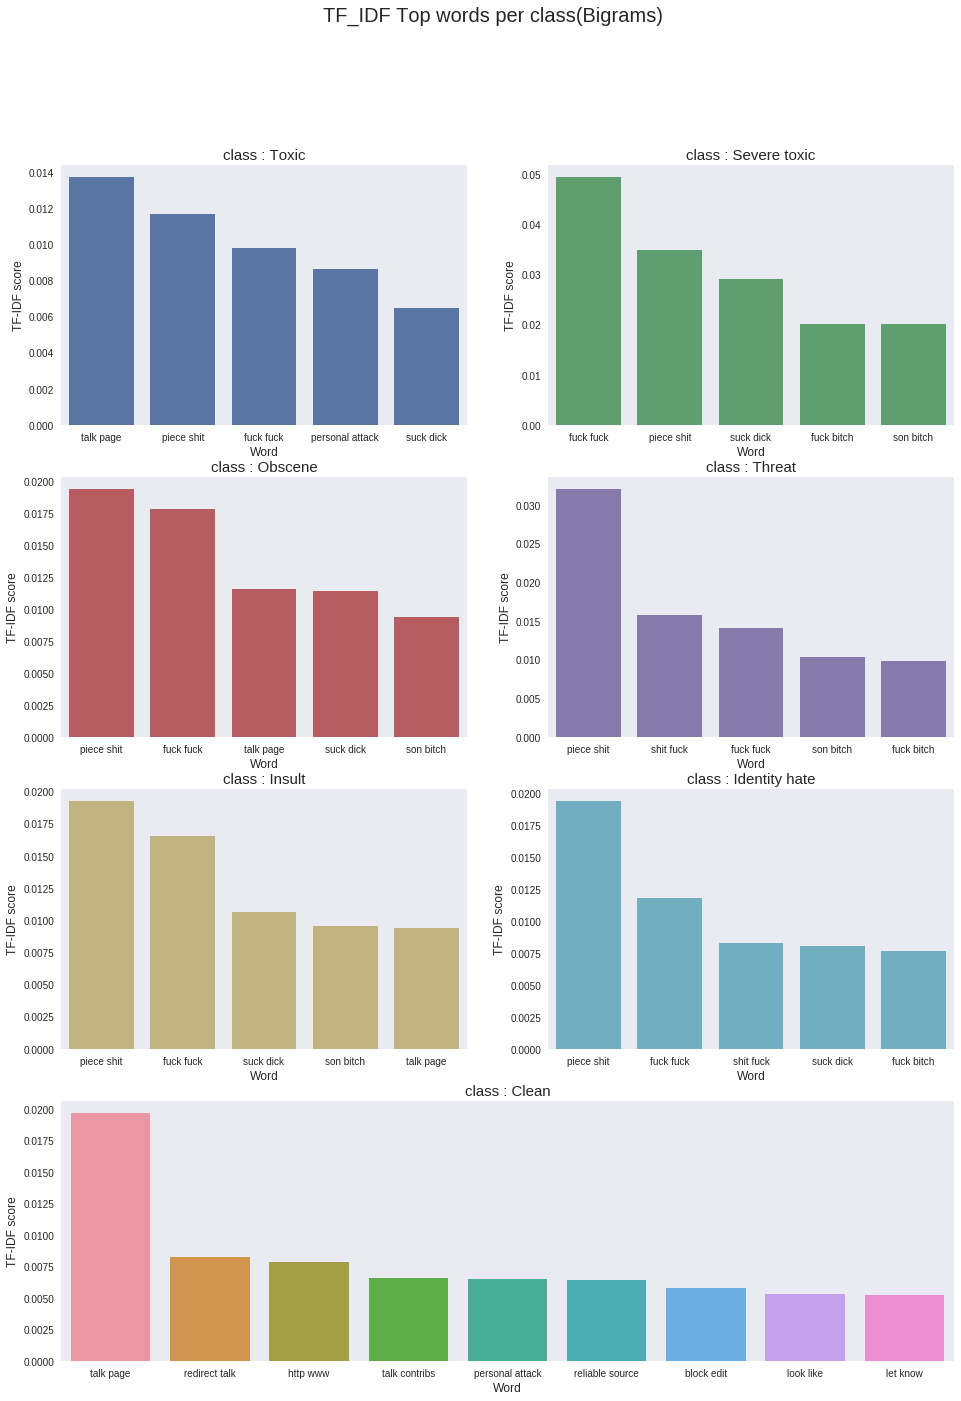

In [0]:
# plot the top-5 TF_IDF score figures for 6 features and top-10 TF_IDF score figures for clean comments sequentially
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

# Method 2:  Use Gensim's package

## Corpus cleaning:

In [0]:
'''
Tokenization
'''
def preprocess(comment):
    return gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)

In [0]:
# tokenization for all text
all_text=corpus.apply(lambda x: preprocess(x))

In [0]:
print("Total number of comments:",len(all_text))
print("Before preprocessing:",corpus.iloc[30])
print("After preprocessing:",all_text.iloc[30])

Total number of comments: 312735
Before preprocessing: How could I post before the block expires?  The funny thing is, you think I'm being uncivil!
After preprocessing: ['how', 'could', 'post', 'before', 'the', 'block', 'expires', 'the', 'funny', 'thing', 'you', 'think', 'being', 'uncivil']


In [0]:
#group together bigrams for all text:  new + york --> new_york
bigram = gensim.models.Phrases(all_text)

In [0]:
#check bigram collation functionality 
print(all_text.iloc[30])
print(bigram[all_text.iloc[30]])

['how', 'could', 'post', 'before', 'the', 'block', 'expires', 'the', 'funny', 'thing', 'you', 'think', 'being', 'uncivil']
['how', 'could', 'post', 'before', 'the', 'block_expires', 'the', 'funny_thing', 'you', 'think', 'being_uncivil']


In [0]:
"""
Function to clean the pre-processed word lists 

Following transformations will be done
1) Stop words removal from the nltk stopword list
2) Bigram collation (Finding common bigrams and grouping them together using gensim.models.phrases)
3) Lemmatization (Stemming, Converting word to its root form : babies --> baby ; children --> child)
"""
def clean(word_list):
    #remove stop words
    clean_words = [w for w in word_list if not w in eng_stopwords]
    #collect bigrams
    clean_words = bigram[clean_words]
    #Lemmatize,stem
    clean_words=[lem.lemmatize(word, "v") for word in clean_words]
    return(clean_words)   

In [0]:
#check clean function
print("Before clean:",all_text.iloc[30])
print("After clean:",clean(all_text.iloc[30]))

Before clean: ['how', 'could', 'post', 'before', 'the', 'block', 'expires', 'the', 'funny', 'thing', 'you', 'think', 'being', 'uncivil']
After clean: ['could', 'post', 'block_expires', 'funny_thing', 'think', 'uncivil']


In [0]:
# clean the all text
all_text=all_text.apply(lambda x:clean(x))

In [0]:
print(type(all_text))

<class 'pandas.core.series.Series'>


In [0]:
for i in range(5):
  print(all_text.iloc[i])

['explanation', 'edit', 'make', 'username', 'hardcore', 'metallica', 'fan', 'revert', 'vandalisms', 'closure', 'gas', 'vote', 'new_york', 'dolls', 'fac', 'please', 'remove', 'template', 'talk_page', 'since', 'retire']
['aww', 'match', 'background', 'colour', 'seemingly', 'stick', 'thank', 'talk', 'january_utc']
['hey_man', 'really', 'try', 'edit_war', 'guy', 'constantly', 'remove', 'relevant', 'information', 'talk', 'edit', 'instead', 'talk_page', 'seem', 'care', 'format', 'actual', 'info']
['make', 'real', 'suggestions', 'improvement', 'wonder', 'section', 'statistics', 'later', 'subsection', 'type', 'accidents', 'think', 'reference', 'may', 'need', 'tidy', 'exact', 'format', 'date_format', 'etc', 'later', 'one', 'else', 'first', 'preferences', 'format', 'style', 'reference', 'want', 'please', 'let_know', 'appear', 'backlog', 'article', 'review', 'guess', 'may', 'delay', 'reviewer', 'turn', 'list', 'relevant', 'form', 'wikipedia', 'transport']
['sir', 'hero', 'chance', 'remember', 'pa

In [0]:
all_text.to_csv("drive/toxic_comment/clean_gensim.csv")

In [0]:
#create the dictionary for all text 
dictionary = Dictionary(all_text)
print("There are",len(dictionary),"number of words in the final dictionary")


There are 322843 number of words in the final dictionary


In [0]:
for i in range(5):
  print(dictionary[i])

closure
dolls
edit
explanation
fac


In [0]:
#convert into lookup tuples within the dictionary using doc2bow(bag of words)
print(dictionary.doc2bow(all_text.iloc[30]))
print("Wordlist from the sentence:",all_text.iloc[30])

[(73, 1), (312, 1), (363, 1), (551, 1), (552, 1), (553, 1)]
Wordlist from the sentence: ['could', 'post', 'block_expires', 'funny_thing', 'think', 'uncivil']


In [0]:
print("Wordlist from the dictionary lookup:", 
      dictionary[73],dictionary[312],dictionary[363],dictionary[551],dictionary[552],dictionary[553])

Wordlist from the dictionary lookup: think could post block_expires funny_thing uncivil


In [0]:
# convert the all text from the dictionary to lookup tuples
corpus2 = [dictionary.doc2bow(text) for text in all_text] # train+test rows, 列是每行评论分词合并(bigrams)后的词组的bag of words 

## Feature Extraction Visualisation:

In [0]:
#create the LDA(Latent Dirichlet Allocation) model
ldamodel = LdaModel(corpus=corpus2, num_topics=15, id2word=dictionary)

In [0]:
pyLDAvis.enable_notebook()

In [0]:
pyLDAvis.gensim.prepare(ldamodel, corpus2, dictionary)   # 

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      16.982538        1       1  0.206941  0.083616
0      13.356177        1       2  0.227026 -0.074843
2      12.391109        1       3  0.212431  0.104099
11     10.431894        1       4  0.211593 -0.001461
1       9.570204        1       5  0.184659 -0.131588
12      6.729587        1       6  0.057471  0.157432
14      6.159667        1       7  0.033991  0.207017
9       4.216830        1       8  0.030317 -0.263905
13      3.155867        1       9 -0.100473  0.133941
8       3.076731        1      10 -0.051113 -0.240256
7       3.011049        1      11 -0.236791  0.063899
4       2.998769        1      12 -0.086548  0.087804
10      2.835927        1      13 -0.238639  0.066274
5       2.573429        1      14 -0.165219 -0.174639
6       2.510220        1      15 -0.285645 -0.017389, topic_info=       Category           Freq             Term          Total  loglift  \
term                                                                      
46      Default  121889.000000          article  121889.000000  30.0000   
79      Default   63788.000000        wikipedia   63788.000000  29.0000   
784     Default   26870.000000             fuck   26870.000000  28.0000   
83      Default   60944.000000             page   60944.000000  27.0000   
2       Default   47748.000000             edit   47748.000000  26.0000   
168     Default   18219.000000            image   18219.000000  25.0000   
11      Default   37005.000000           please   37005.000000  24.0000   
88      Default   50495.000000              use   50495.000000  23.0000   
29      Default   38055.000000            thank   38055.000000  22.0000   
201     Default   33997.000000           source   33997.000000  21.0000   
3630    Default   16770.000000        fuck_fuck   16770.000000  20.0000   
594     Default   17820.000000            block   17820.000000  19.0000   
211030  Default   11162.000000         wtf_omfg   11162.000000  18.0000   
403     Default   36501.000000              get   36501.000000  17.0000   
68      Default   20465.000000          section   20465.000000  16.0000   
277     Default   45111.000000             like   45111.000000  15.0000   
130     Default   28064.000000              add   28064.000000  14.0000   
301     Default   47476.000000              say   47476.000000  13.0000   
16      Default   17556.000000        talk_page   17556.000000  12.0000   
2174    Default   13203.000000             user   13203.000000  11.0000   
73      Default   48005.000000            think   48005.000000  10.0000   
1194    Default   25513.000000             name   25513.000000   9.0000   
179     Default   20349.000000             link   20349.000000   8.0000   
154     Default   16826.000000           delete   16826.000000   7.0000   
934     Default   32973.000000           people   32973.000000   6.0000   
59      Default   18634.000000             list   18634.000000   5.0000   
14      Default   12139.000000           revert   12139.000000   4.0000   
384     Default   34390.000000             know   34390.000000   3.0000   
199     Default   44308.000000              see   44308.000000   2.0000   
760     Default    6973.000000          welcome    6973.000000   1.0000   
...         ...            ...              ...            ...      ...   
85925   Topic15     903.425354    wanker_wanker     904.335022   3.6838   
6076    Topic15     643.188171     edit_request     644.097900   3.6834   
182218  Topic15     557.805359              هست     558.715027   3.6832   
185232  Topic15     532.222046              این     533.131714   3.6831   
322177  Topic15    1382.372559        hole_phck    1384.946045   3.6829   
10880   Topic15     441.497742            wanna     442.407440   3.6827   
181219  Topic15     428.016479              میں     428.926178   3.6827   
82846   Topic15     419.263763         

In [0]:
# print(type(all_text))
# del(corpus)
# del(all_text)
# gc.collect()


## Feature Extaction

In [0]:
#creating the topic probability matrix 
topic_probability_mat = ldamodel[corpus2]

In [0]:
#split it to test and train
train_matrix=topic_probability_mat[:train.shape[0]]
test_matrix=topic_probability_mat[train.shape[0]:]

In [0]:
#convert to sparse format (Csr matrix)
train_sparse=gensim.matutils.corpus2csc(train_matrix)
test_sparse=gensim.matutils.corpus2csc(test_matrix)
